# Random Forest Classification

## Theoretical Foundation

Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees. This approach leverages the wisdom of crowds to achieve superior predictive performance and robustness compared to individual decision trees.

### Decision Trees: The Building Blocks

A decision tree partitions the feature space into rectangular regions by recursively splitting on feature values. At each node, the algorithm selects the feature and threshold that maximizes information gain or minimizes impurity.

**Gini Impurity** measures the probability of incorrectly classifying a randomly chosen element:

$$G(t) = 1 - \sum_{k=1}^{K} p_k^2$$

where $p_k$ is the proportion of class $k$ samples at node $t$, and $K$ is the total number of classes.

**Entropy** (Information Gain criterion) quantifies the uncertainty in the class distribution:

$$H(t) = -\sum_{k=1}^{K} p_k \log_2(p_k)$$

The **information gain** from a split is:

$$\text{IG}(t, \text{split}) = H(t) - \sum_{i \in \{\text{left}, \text{right}\}} \frac{n_i}{n_t} H(i)$$

### Ensemble Methods and Bagging

Random Forest employs **Bootstrap Aggregating (Bagging)**:

1. For each tree $b = 1, 2, \ldots, B$, draw a bootstrap sample $\mathcal{D}_b$ of size $n$ from the training data with replacement
2. Grow a decision tree $T_b$ on $\mathcal{D}_b$
3. At each split, randomly select $m$ features from the $p$ available features (typically $m = \sqrt{p}$ for classification)

The final prediction for classification is determined by **majority voting**:

$$\hat{y} = \text{mode}\{T_1(\mathbf{x}), T_2(\mathbf{x}), \ldots, T_B(\mathbf{x})\}$$

### Variance Reduction

The variance of the ensemble prediction is:

$$\text{Var}(\bar{T}) = \rho \sigma^2 + \frac{1-\rho}{B}\sigma^2$$

where $\rho$ is the average correlation between trees and $\sigma^2$ is the variance of individual trees. By decorrelating trees through random feature selection, Random Forest reduces $\rho$, thereby reducing overall variance.

### Out-of-Bag (OOB) Error Estimation

Since each bootstrap sample contains approximately $1 - e^{-1} \approx 63.2\%$ of unique observations, the remaining samples (out-of-bag) provide a natural validation set. The OOB error is an unbiased estimate of the generalization error.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Set random seed for reproducibility
np.random.seed(42)

## Data Generation

We generate a synthetic binary classification dataset with two features, consisting of two interleaving moon-shaped clusters. This non-linear decision boundary demonstrates the power of Random Forests.

In [2]:
def make_moons(n_samples=500, noise=0.2):
    """Generate two interleaving half circles (moons)."""
    n_samples_per_class = n_samples // 2
    
    # First moon (class 0)
    theta1 = np.linspace(0, np.pi, n_samples_per_class)
    x1 = np.cos(theta1)
    y1 = np.sin(theta1)
    
    # Second moon (class 1) - shifted and flipped
    theta2 = np.linspace(0, np.pi, n_samples_per_class)
    x2 = 1 - np.cos(theta2)
    y2 = 0.5 - np.sin(theta2)
    
    X = np.vstack([np.column_stack([x1, y1]), np.column_stack([x2, y2])])
    y = np.hstack([np.zeros(n_samples_per_class), np.ones(n_samples_per_class)])
    
    # Add Gaussian noise
    X += np.random.randn(*X.shape) * noise
    
    # Shuffle
    idx = np.random.permutation(len(y))
    return X[idx], y[idx].astype(int)

# Generate dataset
X, y = make_moons(n_samples=500, noise=0.25)

# Train-test split
n_train = int(0.8 * len(y))
indices = np.random.permutation(len(y))
X_train, X_test = X[indices[:n_train]], X[indices[n_train:]]
y_train, y_test = y[indices[:n_train]], y[indices[n_train:]]

print(f"Training samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")
print(f"Class distribution (train): {dict(zip(*np.unique(y_train, return_counts=True)))}")

Training samples: 400
Test samples: 100
Class distribution (train): {np.int64(0): np.int64(204), np.int64(1): np.int64(196)}


## Decision Tree Implementation

We implement a decision tree classifier from scratch using the Gini impurity criterion.

In [3]:
class DecisionNode:
    """A node in the decision tree."""
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx  # Index of feature to split on
        self.threshold = threshold       # Threshold value for split
        self.left = left                 # Left child (feature <= threshold)
        self.right = right               # Right child (feature > threshold)
        self.value = value               # Predicted class (for leaf nodes)


class DecisionTreeClassifier:
    """Decision Tree Classifier using Gini impurity."""
    
    def __init__(self, max_depth=10, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.root = None
    
    def _gini(self, y):
        """Calculate Gini impurity."""
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _best_split(self, X, y, feature_indices):
        """Find the best split for a node."""
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        
        parent_gini = self._gini(y)
        n = len(y)
        
        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                # Calculate weighted Gini impurity after split
                n_left, n_right = np.sum(left_mask), np.sum(right_mask)
                gini_left = self._gini(y[left_mask])
                gini_right = self._gini(y[right_mask])
                weighted_gini = (n_left * gini_left + n_right * gini_right) / n
                
                # Information gain
                gain = parent_gini - weighted_gini
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree."""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Stopping criteria
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            n_classes == 1):
            leaf_value = Counter(y).most_common(1)[0][0]
            return DecisionNode(value=leaf_value)
        
        # Random feature selection (for Random Forest)
        if self.max_features is not None:
            feature_indices = np.random.choice(n_features, 
                                               min(self.max_features, n_features), 
                                               replace=False)
        else:
            feature_indices = np.arange(n_features)
        
        # Find best split
        best_feature, best_threshold, best_gain = self._best_split(X, y, feature_indices)
        
        if best_feature is None or best_gain <= 0:
            leaf_value = Counter(y).most_common(1)[0][0]
            return DecisionNode(value=leaf_value)
        
        # Split data and recurse
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return DecisionNode(feature_idx=best_feature, threshold=best_threshold,
                           left=left_child, right=right_child)
    
    def fit(self, X, y):
        """Train the decision tree."""
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        """Predict class for a single sample."""
        if node.value is not None:
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """Predict classes for multiple samples."""
        return np.array([self._predict_sample(x, self.root) for x in X])

## Random Forest Implementation

The Random Forest aggregates predictions from multiple decision trees, each trained on a bootstrap sample with random feature selection.

In [4]:
class RandomForestClassifier:
    """Random Forest Classifier using bootstrap aggregating."""
    
    def __init__(self, n_estimators=100, max_depth=10, min_samples_split=2, 
                 max_features='sqrt', oob_score=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.oob_score = oob_score
        self.trees = []
        self.oob_indices = []
        self.oob_score_ = None
    
    def _bootstrap_sample(self, X, y):
        """Generate a bootstrap sample."""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        oob_mask = np.ones(n_samples, dtype=bool)
        oob_mask[np.unique(indices)] = False
        return X[indices], y[indices], np.where(oob_mask)[0]
    
    def fit(self, X, y):
        """Train the Random Forest."""
        n_samples, n_features = X.shape
        
        # Determine max_features
        if self.max_features == 'sqrt':
            max_feat = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_feat = int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            max_feat = self.max_features
        else:
            max_feat = n_features
        
        self.trees = []
        self.oob_indices = []
        
        # Train each tree
        for i in range(self.n_estimators):
            X_boot, y_boot, oob_idx = self._bootstrap_sample(X, y)
            
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=max_feat
            )
            tree.fit(X_boot, y_boot)
            
            self.trees.append(tree)
            self.oob_indices.append(oob_idx)
        
        # Calculate OOB score
        if self.oob_score:
            self._compute_oob_score(X, y)
        
        return self
    
    def _compute_oob_score(self, X, y):
        """Compute Out-of-Bag score."""
        n_samples = X.shape[0]
        oob_predictions = np.zeros((n_samples, 2))  # Count votes for each class
        
        for tree, oob_idx in zip(self.trees, self.oob_indices):
            if len(oob_idx) > 0:
                preds = tree.predict(X[oob_idx])
                for i, idx in enumerate(oob_idx):
                    oob_predictions[idx, preds[i]] += 1
        
        # Get samples with at least one OOB prediction
        valid_samples = np.sum(oob_predictions, axis=1) > 0
        final_predictions = np.argmax(oob_predictions[valid_samples], axis=1)
        
        self.oob_score_ = np.mean(final_predictions == y[valid_samples])
    
    def predict(self, X):
        """Predict classes using majority voting."""
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote
        return np.array([Counter(predictions[:, i]).most_common(1)[0][0] 
                        for i in range(X.shape[0])])
    
    def predict_proba(self, X):
        """Predict class probabilities."""
        predictions = np.array([tree.predict(X) for tree in self.trees])
        proba = np.zeros((X.shape[0], 2))
        
        for i in range(X.shape[0]):
            counts = np.bincount(predictions[:, i], minlength=2)
            proba[i] = counts / self.n_estimators
        
        return proba

## Model Training and Evaluation

In [5]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', oob_score=True)
rf.fit(X_train, y_train)

# Predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Calculate metrics
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

train_acc = accuracy(y_train, y_pred_train)
test_acc = accuracy(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"OOB Score: {rf.oob_score_:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN={cm[0,0]:3d}  FP={cm[0,1]:3d}")
print(f"  FN={cm[1,0]:3d}  TP={cm[1,1]:3d}")

Training Accuracy: 1.0000
Test Accuracy: 0.9300
OOB Score: 0.9300

Confusion Matrix:
  TN= 44  FP=  2
  FN=  5  TP= 49


## Visualization

We visualize the decision boundary learned by the Random Forest, along with the effect of ensemble size on accuracy.

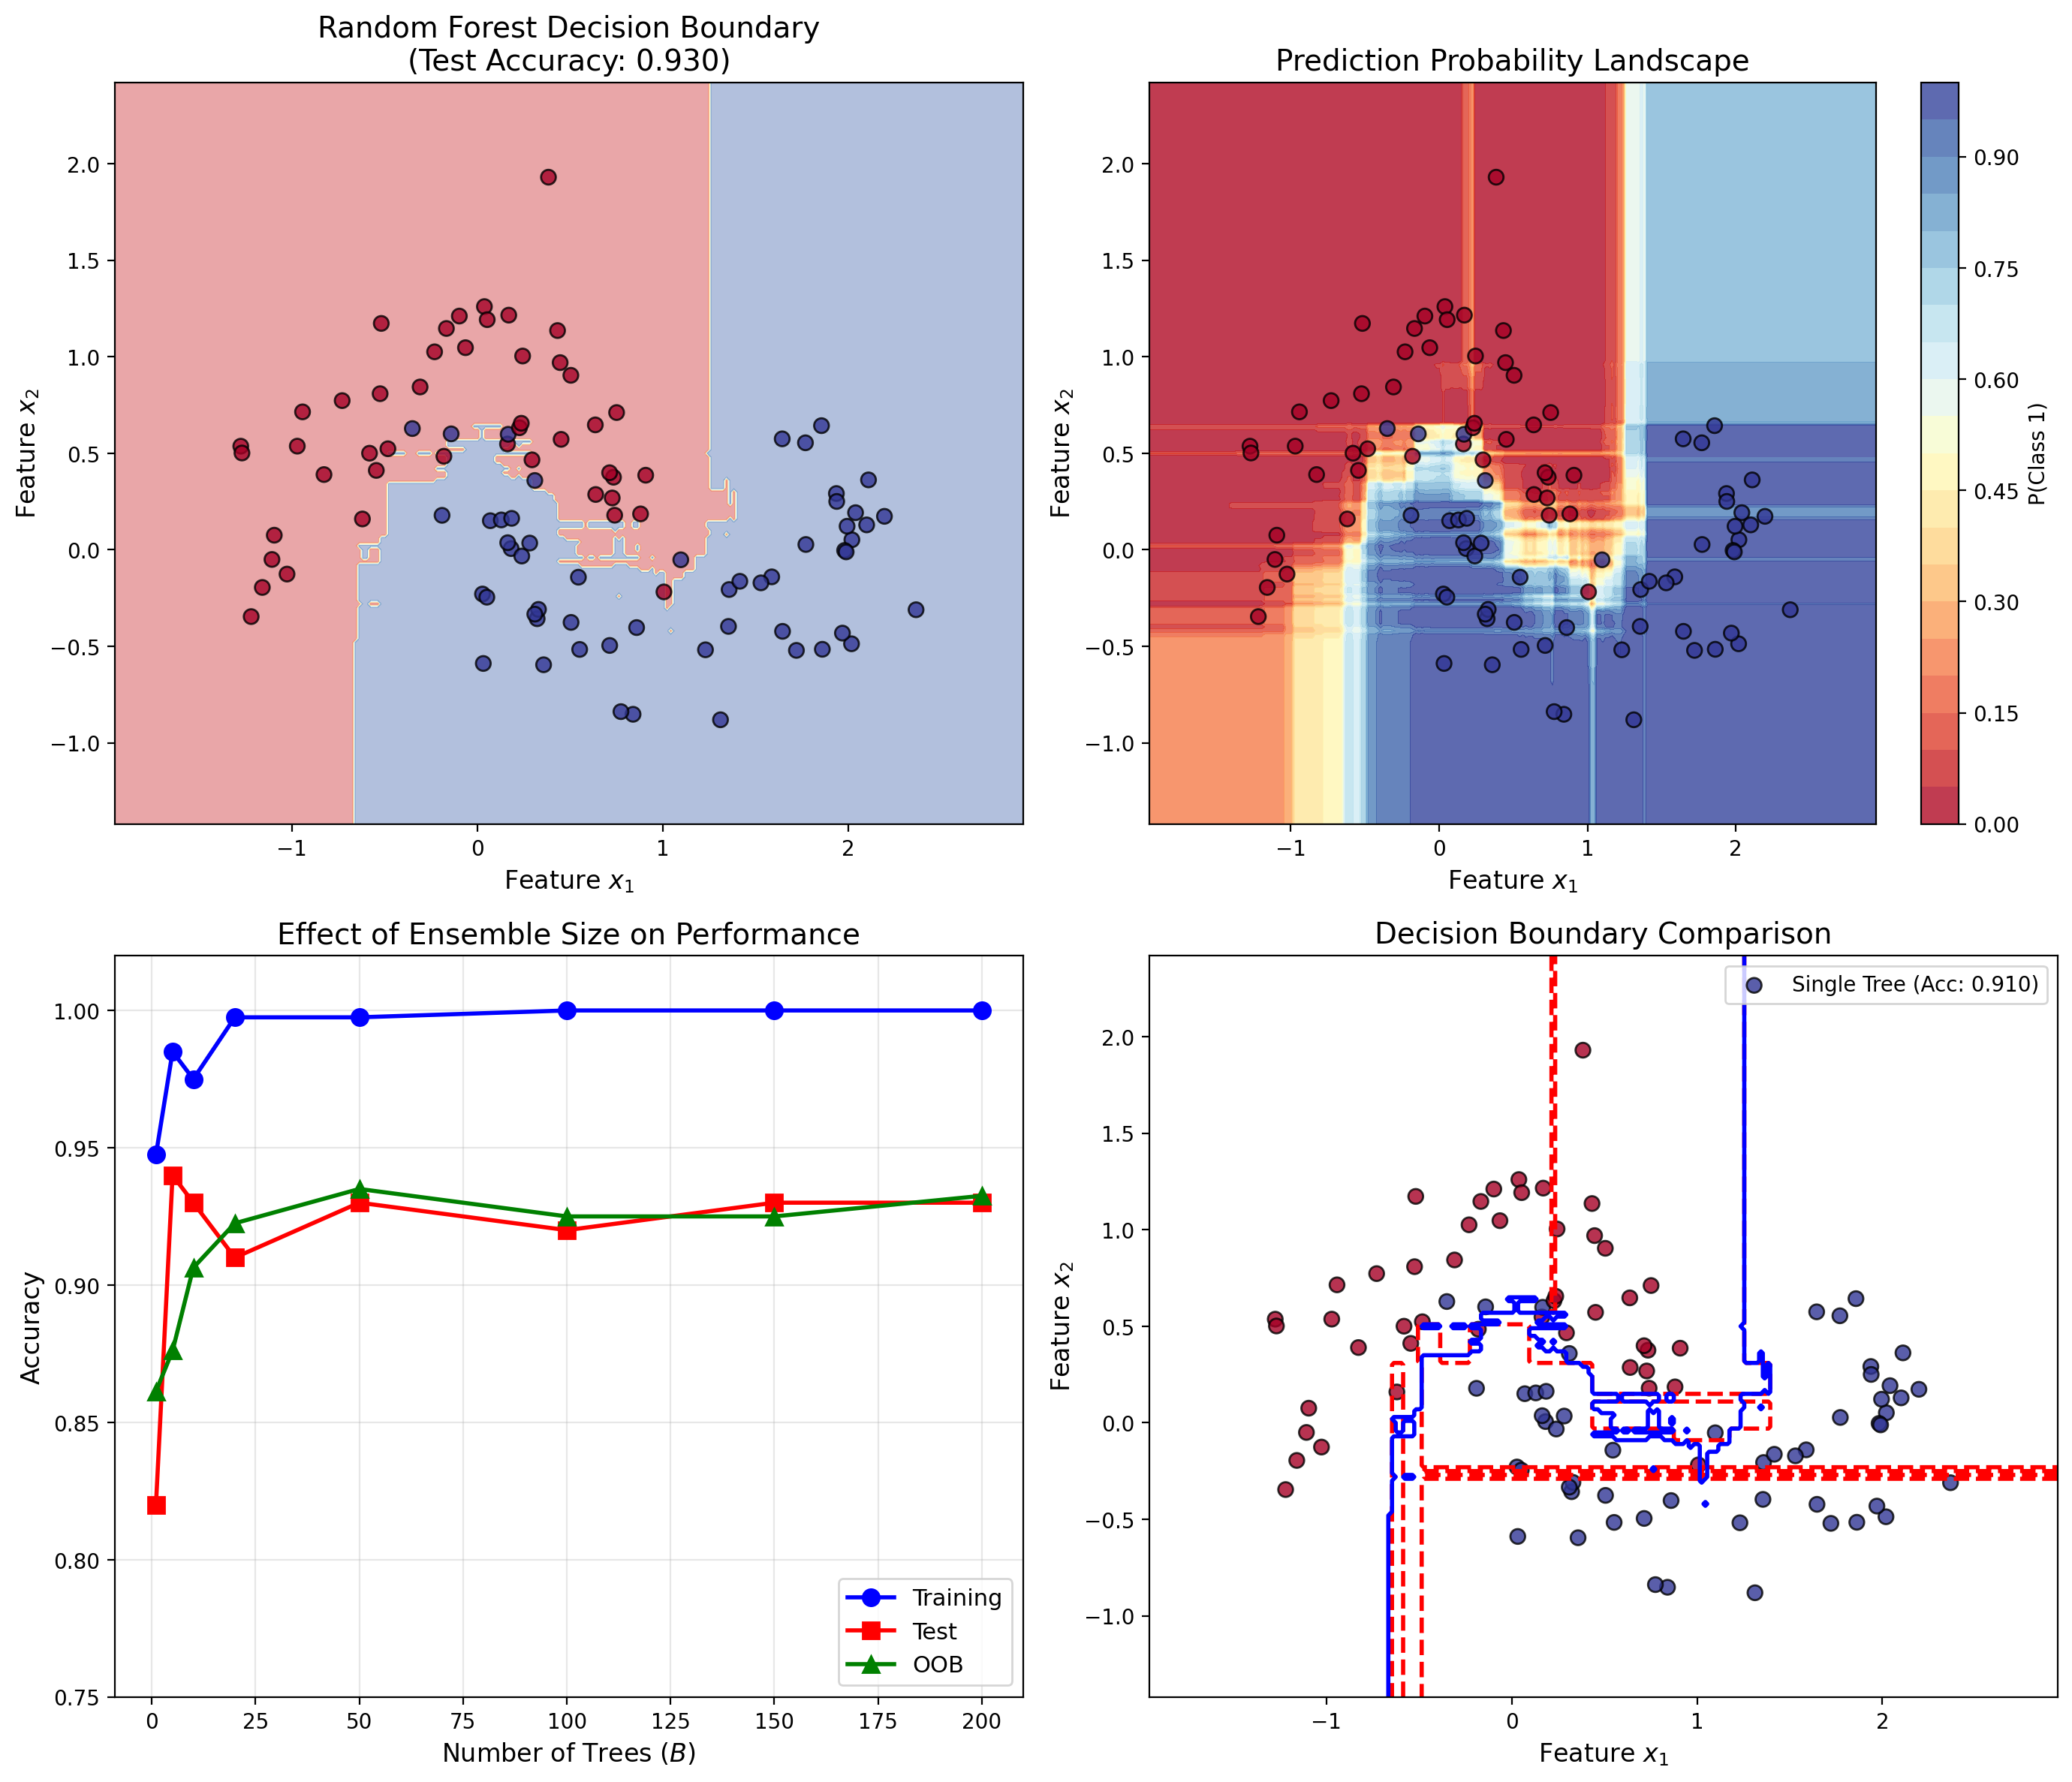


Figure saved to plot.png


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Decision Boundary
ax1 = axes[0, 0]
h = 0.02  # Step size in mesh
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = rf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax1.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', 
            edgecolors='black', s=50, alpha=0.8)
ax1.set_xlabel('Feature $x_1$', fontsize=12)
ax1.set_ylabel('Feature $x_2$', fontsize=12)
ax1.set_title(f'Random Forest Decision Boundary\n(Test Accuracy: {test_acc:.3f})', fontsize=14)

# 2. Prediction Probabilities
ax2 = axes[0, 1]
proba = rf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
proba = proba.reshape(xx.shape)

contour = ax2.contourf(xx, yy, proba, levels=20, cmap='RdYlBu', alpha=0.8)
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', 
            edgecolors='black', s=50, alpha=0.8)
plt.colorbar(contour, ax=ax2, label='P(Class 1)')
ax2.set_xlabel('Feature $x_1$', fontsize=12)
ax2.set_ylabel('Feature $x_2$', fontsize=12)
ax2.set_title('Prediction Probability Landscape', fontsize=14)

# 3. Effect of Number of Trees
ax3 = axes[1, 0]
n_trees_range = [1, 5, 10, 20, 50, 100, 150, 200]
train_scores = []
test_scores = []
oob_scores = []

for n_trees in n_trees_range:
    rf_temp = RandomForestClassifier(n_estimators=n_trees, max_depth=10, oob_score=True)
    rf_temp.fit(X_train, y_train)
    train_scores.append(accuracy(y_train, rf_temp.predict(X_train)))
    test_scores.append(accuracy(y_test, rf_temp.predict(X_test)))
    oob_scores.append(rf_temp.oob_score_)

ax3.plot(n_trees_range, train_scores, 'b-o', label='Training', linewidth=2, markersize=8)
ax3.plot(n_trees_range, test_scores, 'r-s', label='Test', linewidth=2, markersize=8)
ax3.plot(n_trees_range, oob_scores, 'g-^', label='OOB', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Trees ($B$)', fontsize=12)
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_title('Effect of Ensemble Size on Performance', fontsize=14)
ax3.legend(loc='lower right', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0.75, 1.02])

# 4. Single Tree vs Random Forest Comparison
ax4 = axes[1, 1]

# Train single decision tree
single_tree = DecisionTreeClassifier(max_depth=10)
single_tree.fit(X_train, y_train)
Z_tree = single_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot side by side comparison using contours
ax4.contour(xx, yy, Z_tree, levels=[0.5], colors='red', linewidths=2, linestyles='--')
ax4.contour(xx, yy, Z, levels=[0.5], colors='blue', linewidths=2, linestyles='-')
ax4.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', 
            edgecolors='black', s=50, alpha=0.8)

tree_acc = accuracy(y_test, single_tree.predict(X_test))
ax4.set_xlabel('Feature $x_1$', fontsize=12)
ax4.set_ylabel('Feature $x_2$', fontsize=12)
ax4.set_title('Decision Boundary Comparison', fontsize=14)
ax4.legend([f'Single Tree (Acc: {tree_acc:.3f})', 
            f'Random Forest (Acc: {test_acc:.3f})'], 
           loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('random_forest_classification_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved to plot.png")

## Key Insights

1. **Ensemble Advantage**: The Random Forest produces smoother decision boundaries compared to a single decision tree, reducing overfitting.

2. **Convergence Behavior**: As the number of trees increases, both training and test accuracy stabilize, demonstrating that adding more trees beyond a certain point yields diminishing returns.

3. **OOB Estimation**: The Out-of-Bag score provides a reliable estimate of generalization performance without requiring a separate validation set.

4. **Probabilistic Predictions**: The probability landscape shows how confidence varies across the feature space, with higher uncertainty near the decision boundary.

### Computational Complexity

- **Training**: $O(B \cdot n \cdot m \cdot \log n)$ where $B$ is the number of trees, $n$ is the number of samples, and $m$ is the number of features considered at each split
- **Prediction**: $O(B \cdot \log n)$ per sample

Random Forests are embarrassingly parallel—each tree can be trained independently, making them highly scalable for large datasets.